Import libraries

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import pickle

Read in and parse data

In [15]:
df = pd.read_csv('tomtom.tsv', sep='\t')
df = df.rename(columns={
    'Query_ID': 'query',
    'Target_ID': 'target',
    'p-value': 'p_value',
    'E-value': 'e_value',
    'q-value': 'q_value'
})[['query', 'target', 'p_value', 'e_value', 'q_value']]

In [16]:
motifs = pd.unique(df[['query', 'target']].values.ravel())

Fill Distance Matrices

In [5]:
p_mat = pd.DataFrame(np.nan, index=motifs, columns=motifs)
e_mat = pd.DataFrame(np.nan, index=motifs, columns=motifs)
q_mat = pd.DataFrame(np.nan, index=motifs, columns=motifs)

In [12]:
for _, row in df.iterrows():
    qi = row['query']
    ti = row['target']
    p_mat.at[qi, ti] = row['p_value']
    p_mat.at[ti, qi] = row['p_value']
    e_mat.at[qi, ti] = row['e_value']
    e_mat.at[ti, qi] = row['e_value']
    q_mat.at[qi, ti] = row['q_value']
    q_mat.at[ti, qi] = row['q_value']

In [8]:
np.fill_diagonal(p_mat.values, 0.0)
np.fill_diagonal(e_mat.values, 0.0)
np.fill_diagonal(q_mat.values, 0.0)

In [40]:
# filtering extra

mapping = pd.read_csv('mapping.csv')
m_ids = mapping['motif_id'].tolist()
fams = mapping['family'].tolist()
keep_ids = [m for m in p_mat.index if m in m_ids]

p_mat = p_mat.loc[keep_ids, keep_ids]
e_mat = e_mat.loc[keep_ids, keep_ids]
q_mat = q_mat.loc[keep_ids, keep_ids]

In [41]:
fams

['Basic helix-loop-helix factors (bHLH)',
 'C2H2 zinc finger factors',
 'Other C4 zinc finger-type factors',
 'Rel homology region (RHR) factors',
 'Rel homology region (RHR) factors',
 'Tryptophan cluster factors',
 'C2H2 zinc finger factors',
 'Other C4 zinc finger-type factors',
 'Tryptophan cluster factors',
 'Other C4 zinc finger-type factors',
 'Paired box factors',
 'Nuclear receptors with C4 zinc fingers',
 'Basic leucine zipper factors (bZIP)',
 'Basic leucine zipper factors (bZIP)',
 'Rel homology region (RHR) factors',
 'Rel homology region (RHR) factors',
 'Basic helix-loop-helix factors (bHLH)',
 'C2H2 zinc finger factors',
 'AP2/EREBP',
 'Basic leucine zipper factors (bZIP)',
 'Basic leucine zipper factors (bZIP)',
 'C2H2 zinc finger factors',
 'Tryptophan cluster factors',
 'C2H2 zinc finger factors',
 'C2H2 zinc finger factors',
 'Homeo domain factors',
 'Homeo domain factors',
 'Homeo domain factors',
 'Homeo domain factors',
 'Homeo domain factors',
 'Homeo domain fac

In [33]:
# p_mat.to_csv('p_value_matrix.csv')
# e_mat.to_csv('e_value_matrix.csv')
# q_mat.to_csv('q_value_matrix.csv')

In [25]:
q_mat = pd.read_csv('q_value_matrix.csv',index_col=0)
q_mat = q_mat.astype(float)

Transform statistical measures to similarity/distance values

In [26]:
# find non-zero min, and map q to range of [0, 35]
q_min = q_mat[q_mat>0].min().min()
q_floor = q_mat.replace(0,q_min)
sim = -np.log10(q_floor)

In [27]:
sim_vals = sim.values.flatten()

In [28]:
print(pd.Series(sim_vals).describe())

count    4.464769e+06
mean     1.080221e-01
std      8.739195e-01
min     -0.000000e+00
25%      8.137612e-04
50%      4.112637e-03
75%      2.661996e-02
max      3.406989e+01
dtype: float64


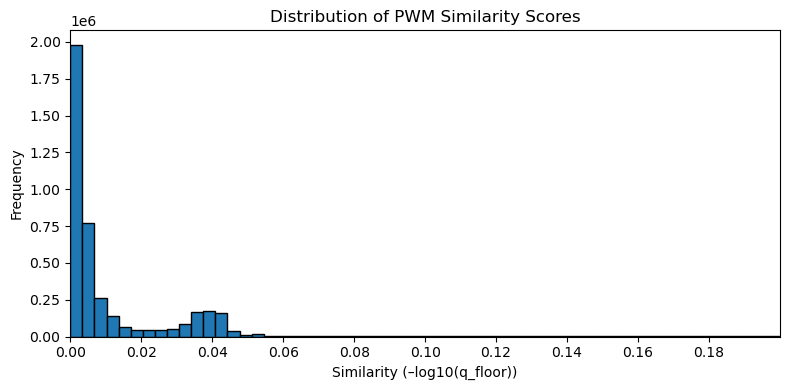

In [150]:
plt.figure(figsize=(8, 4))
plt.hist(sim_vals, bins=10000, edgecolor='black')
plt.xlim(0,0.2)
plt.xlabel('Similarity (–log10(q_floor))')
plt.xticks(np.arange(0,0.2,0.02))
plt.ylabel('Frequency')
plt.title('Distribution of PWM Similarity Scores')
plt.tight_layout()
plt.show()

Visualize Similarity matrix

In [30]:
family_counts = mapping['family'].value_counts()
families = family_counts.index.tolist()

In [31]:
ordered_ids = []
sizes = []
for fam in families:
    ids = mapping.loc[mapping['family'] == fam, 'motif_id'].sort_values()
    ordered_ids.extend(ids.1000tolist())
    sizes.append(len(ids))

In [32]:
sim_sorted = sim.loc[ordered_ids, ordered_ids]

In [33]:
boundaries = np.cumsum(sizes)
starts = np.concatenate(([0], boundaries[:-1]))
ends = boundaries
midpoints = (starts + ends) / 2

In [75]:
p99 = np.percentile(sim.values, 98)
sim_clip = np.minimum(sim_sorted, p99)

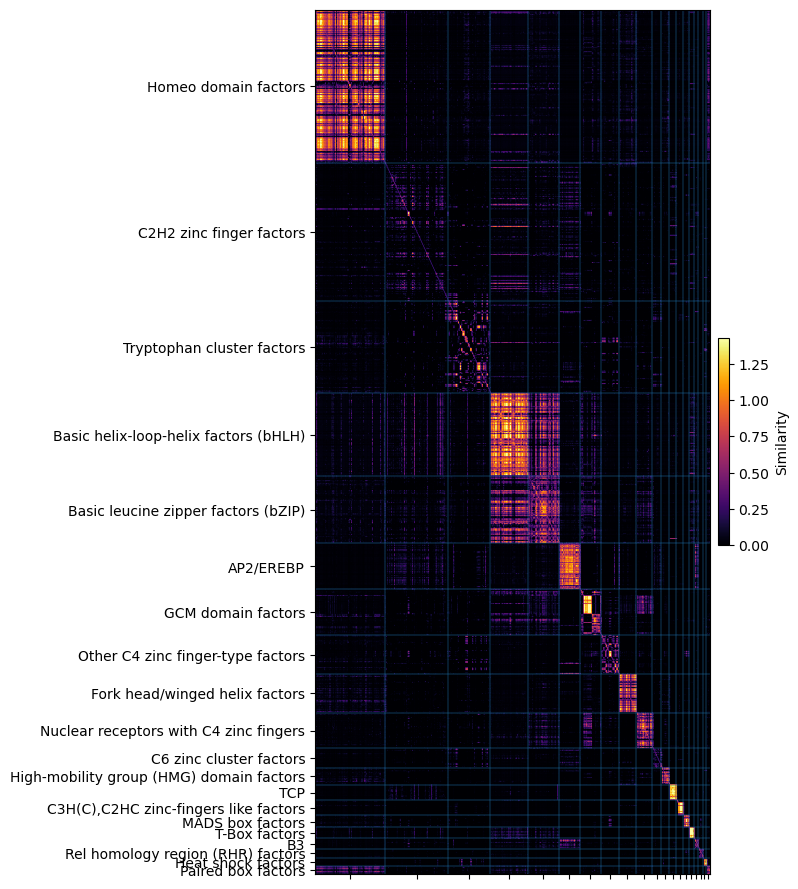

In [76]:
fig, ax = plt.subplots(figsize=(8, 9))
im = ax.imshow(sim_clip, aspect='auto', cmap='inferno')
cbar = plt.colorbar(im, ax=ax, label='Similarity', fraction=0.025, pad=0.02)

# Draw lines between family blocks
for b in boundaries[:-1]:
    ax.axhline(b - 0.5, linewidth=0.35)
    ax.axvline(b - 0.5, linewidth=0.35)

# Set tick labels at block midpoints
ax.set_xticks(midpoints)
ax.set_xticklabels("", rotation=90, fontsize=1)
ax.set_yticks(midpoints)
ax.set_yticklabels(families, fontsize=10)

plt.tight_layout()
plt.show()

Visualize summary statistic

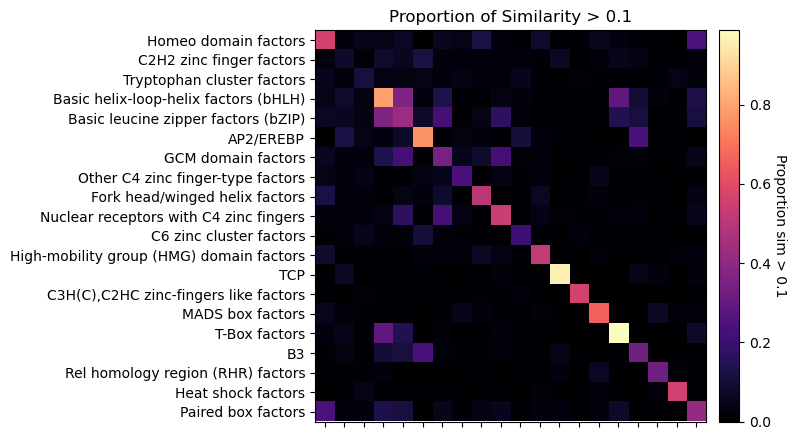

In [149]:
threshold = 0.1  # adjust as needed
df_prop = pd.DataFrame(index=families, columns=families, dtype=float)

for f1 in families:
    ids1 = mapping.loc[mapping['family'] == f1, 'motif_id'].tolist()
    for f2 in families:
        ids2 = mapping.loc[mapping['family'] == f2, 'motif_id'].tolist()
        block = sim_sorted.loc[ids1, ids2].values.flatten()
        if f1 == f2:
            n = len(ids1)
            tri = np.triu_indices(n, k=1)
            block = sim_sorted.loc[ids1, ids1].values[tri]
        df_prop.at[f1, f2] = np.mean(block > threshold)

# --- 4. Plot the proportion heatmap ---
fig, ax = plt.subplots(figsize=(8, 4.5))
im = ax.imshow(df_prop.values, cmap='magma', aspect='equal')
cbar = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.02)
cbar.ax.set_ylabel(f'Proportion sim > {threshold}', rotation=270, labelpad=12)

# Label ticks
ax.set_xticks(np.arange(len(families)))
ax.set_xticklabels("", rotation=90, fontsize=8)
ax.set_yticks(np.arange(len(families)))
ax.set_yticklabels(families, fontsize=10)

ax.set_title(f'Proportion of Similarity > {threshold}')
plt.tight_layout()
plt.show()

Getting DL Confusion matrix

In [96]:
with open('03_26_10fold.pkl', 'rb') as f:
    y_pred_DL = pickle.load(f)
with open('id_to_fam.pkl', 'rb') as f:
    id_to_fam = pickle.load(f)

y_pred_DL

[3,
 1,
 1,
 17,
 17,
 2,
 11,
 7,
 2,
 7,
 0,
 9,
 4,
 9,
 17,
 17,
 1,
 6,
 5,
 4,
 4,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 16,
 11,
 10,
 2,
 7,
 10,
 4,
 7,
 7,
 8,
 10,
 2,
 10,
 0,
 3,
 3,
 1,
 2,
 16,
 14,
 3,
 1,
 1,
 1,
 10,
 10,
 0,
 3,
 1,
 1,
 1,
 17,
 11,
 1,
 10,
 10,
 10,
 5,
 10,
 10,
 2,
 3,
 9,
 4,
 10,
 0,
 10,
 10,
 10,
 1,
 0,
 11,
 8,
 4,
 0,
 1,
 1,
 1,
 6,
 7,
 0,
 11,
 9,
 0,
 1,
 10,
 7,
 0,
 5,
 8,
 6,
 14,
 3,
 3,
 3,
 5,
 2,
 3,
 3,
 3,
 1,
 4,
 4,
 8,
 8,
 3,
 2,
 8,
 8,
 0,
 19,
 2,
 4,
 14,
 3,
 3,
 3,
 3,
 9,
 3,
 0,
 9,
 1,
 15,
 15,
 3,
 1,
 0,
 0,
 0,
 9,
 9,
 9,
 0,
 1,
 1,
 1,
 1,
 1,
 8,
 19,
 19,
 14,
 0,
 2,
 5,
 17,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 15,
 15,
 15,
 15,
 

In [97]:
y_pred_DL = [id_to_fam[id] for id in y_pred_DL]
y_pred_DL

['Basic helix-loop-helix factors (bHLH)',
 'C2H2 zinc finger factors',
 'C2H2 zinc finger factors',
 'Rel homology region (RHR) factors',
 'Rel homology region (RHR) factors',
 'Tryptophan cluster factors',
 'High-mobility group (HMG) domain factors',
 'Other C4 zinc finger-type factors',
 'Tryptophan cluster factors',
 'Other C4 zinc finger-type factors',
 'Homeo domain factors',
 'Nuclear receptors with C4 zinc fingers',
 'Basic leucine zipper factors (bZIP)',
 'Nuclear receptors with C4 zinc fingers',
 'Rel homology region (RHR) factors',
 'Rel homology region (RHR) factors',
 'C2H2 zinc finger factors',
 'GCM domain factors',
 'AP2/EREBP',
 'Basic leucine zipper factors (bZIP)',
 'Basic leucine zipper factors (bZIP)',
 'C2H2 zinc finger factors',
 'C2H2 zinc finger factors',
 'C2H2 zinc finger factors',
 'C2H2 zinc finger factors',
 'Homeo domain factors',
 'Homeo domain factors',
 'Homeo domain factors',
 'Homeo domain factors',
 'Homeo domain factors',
 'Homeo domain factors',
 '

In [98]:
fams

['Basic helix-loop-helix factors (bHLH)',
 'C2H2 zinc finger factors',
 'Other C4 zinc finger-type factors',
 'Rel homology region (RHR) factors',
 'Rel homology region (RHR) factors',
 'Tryptophan cluster factors',
 'C2H2 zinc finger factors',
 'Other C4 zinc finger-type factors',
 'Tryptophan cluster factors',
 'Other C4 zinc finger-type factors',
 'Paired box factors',
 'Nuclear receptors with C4 zinc fingers',
 'Basic leucine zipper factors (bZIP)',
 'Basic leucine zipper factors (bZIP)',
 'Rel homology region (RHR) factors',
 'Rel homology region (RHR) factors',
 'Basic helix-loop-helix factors (bHLH)',
 'C2H2 zinc finger factors',
 'AP2/EREBP',
 'Basic leucine zipper factors (bZIP)',
 'Basic leucine zipper factors (bZIP)',
 'C2H2 zinc finger factors',
 'Tryptophan cluster factors',
 'C2H2 zinc finger factors',
 'C2H2 zinc finger factors',
 'Homeo domain factors',
 'Homeo domain factors',
 'Homeo domain factors',
 'Homeo domain factors',
 'Homeo domain factors',
 'Homeo domain fac

Analyze

In [99]:
from sklearn.metrics import accuracy_score

In [100]:
accuracy = accuracy_score(fams, y_pred_DL)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8202


In [208]:
summary = []
for fam in families:
    intra_prop = df_prop.at[fam, fam]
    inter_values = df_prop.loc[fam].drop(fam).values
    mean_inter = inter_values.mean()
    max_inter = inter_values.max()
    sum_inter = inter_values.sum()
    summary.append({
        'family': fam,
        'intra_prop': intra_prop,
        'mean_inter_prop': mean_inter,
        'max_inter_prop': max_inter,
        'sum_inter_prop': sum_inter,
    })

df_summary = pd.DataFrame(summary).set_index('family')

In [247]:
import scipy.stats as stats

summary = []
for fam in families:
    intra_prop = df_prop.at[fam, fam]
    inter_values = df_prop.loc[fam].drop(fam).values

    # basic moments
    mean_inter   = inter_values.mean()
    std_inter    = inter_values.std(ddof=1)                       # sample‐std
    median_inter = np.median(inter_values)
    iqr_inter    = np.percentile(inter_values, 75) - np.percentile(inter_values, 25)
    skew_inter   = stats.skew(inter_values)
    kurt_inter   = stats.kurtosis(inter_values)

    # min/max/sum
    min_inter = inter_values.min()
    max_inter = inter_values.max()
    sum_inter = inter_values.sum()

    

    summary.append({
        'family':            fam,
        
        'intra_prop':        intra_prop,

        'min_inter_prop':    min_inter,
        'max_inter_prop':    max_inter,
        'median_inter_prop': median_inter,
        'iqr_inter_prop':    iqr_inter,
        'mean_inter_prop':   mean_inter,
        'std_inter_prop':    std_inter,
        'skew_inter_prop':   skew_inter,
        'kurtosis_inter_prop': kurt_inter
    })

df_summary = pd.DataFrame(summary).set_index('family')

In [248]:
df_summary

,intra_prop,min_inter_prop,max_inter_prop,median_inter_prop,iqr_inter_prop,mean_inter_prop,std_inter_prop,skew_inter_prop,kurtosis_inter_prop
family,,,,,,,,,
Homeo domain factors,0.563865,0.000070,0.239467,0.029436,0.047056,0.046454,0.056240,2.310282,5.443539
C2H2 zinc finger factors,0.080437,0.002406,0.121189,0.019991,0.023895,0.033125,0.030013,1.643516,2.051663
Tryptophan cluster factors,0.112645,0.001863,0.052268,0.022480,0.022518,0.024701,0.014892,0.328967,-0.958193
Basic helix-loop-helix factors (bHLH),0.796070,0.005224,0.365596,0.029807,0.079741,0.070585,0.099412,1.979145,2.926207
Basic leucine zipper factors (bZIP),0.431190,0.001653,0.365596,0.039458,0.102995,0.077041,0.094388,1.726068,2.649538
AP2/EREBP,0.765329,0.000000,0.228387,0.011457,0.033006,0.038528,0.058040,2.142178,4.136396
GCM domain factors,0.347008,0.000000,0.222240,0.022866,0.043389,0.051949,0.068096,1.741620,1.747974
Other C4 zinc finger-type factors,0.238074,0.000277,0.050752,0.012632,0.027431,0.019347,0.016568,0.562612,-1.030384
Fork head/winged helix factors,0.507207,0.002240,0.121730,0.014222,0.021264,0.027238,0.031028,1.897477,2.887691


Model 1 R² = 0.614
Model 2 R² = 0.453


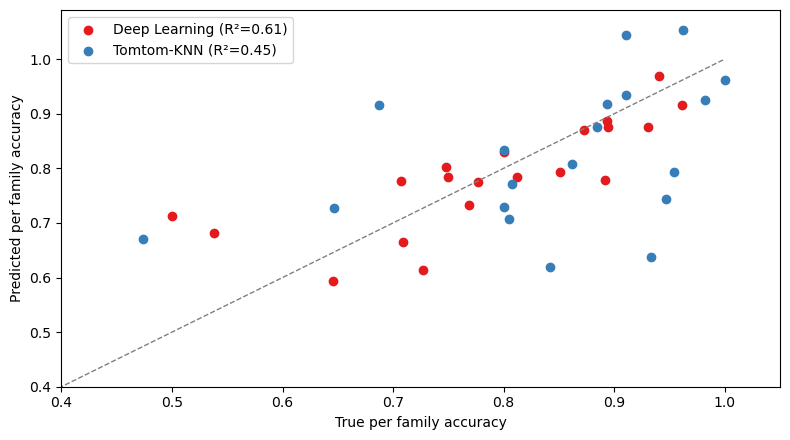

In [251]:
from sklearn.linear_model import LinearRegression

X = df_summary.values
accuracy_KNN = np.array([0.9626666666666667, 0.6468842729970327, 0.8938053097345132, 0.9104477611940298, 0.8848484848484849, 0.9823008849557522, 0.9107142857142857, 0.8421052631578947, 0.9468085106382979, 0.8620689655172413, 0.6875, 0.8048780487804879, 0.47368421052631576, 0.0, 0.9333333333333333, 1.0, 0.8076923076923077, 0.9545454545454546, 0.8, 0.8])
accuracy_DL = np.array([0.9306666666666666, 0.7091988130563798, 0.7477876106194691, 0.9402985074626866, 0.8727272727272727, 0.8938053097345132, 0.8125, 0.7684210526315789, 0.776595744680851, 0.8505747126436781, 0.6458333333333334, 0.7073170731707317, 0.8947368421052632, 0.8918918918918919, 0.8, 0.9615384615384616, 0.5384615384615384, 0.7272727272727273, 0.5, 0.75])

model_DL = LinearRegression().fit(X, accuracy_DL)
model_KNN = LinearRegression().fit(X, accuracy_KNN)

r2_1 = model_DL.score(X, accuracy_DL)
r2_2 = model_KNN.score(X, accuracy_KNN)
print(f'Model 1 R² = {r2_1:.3f}')
print(f'Model 2 R² = {r2_2:.3f}')

y1_pred = model_DL.predict(X)
y2_pred = model_KNN.predict(X)

plt.figure(figsize=(8,4.5))
plt.scatter(accuracy_DL, y1_pred, label=f'Deep Learning (R²={r2_1:.2f})', color='#e41a1c')
plt.scatter(accuracy_KNN, y2_pred, label=f'Tomtom-KNN (R²={r2_2:.2f})', color='#377eb8')

lims = [min(accuracy_DL.min(), accuracy_KNN.min()), max(accuracy_DL.max(), accuracy_KNN.max())]
plt.plot(lims, lims, '--', color='gray', linewidth=1)
plt.xlabel('True per family accuracy')
plt.ylabel('Predicted per family accuracy')
plt.xlim(0.4,1.05)
plt.ylim(0.4,1.09)
plt.legend()
plt.tight_layout()
plt.show()

DL:  Pearson r = 0.407, p = 0.0752
KNN: Pearson r = 0.435, p = 0.0555


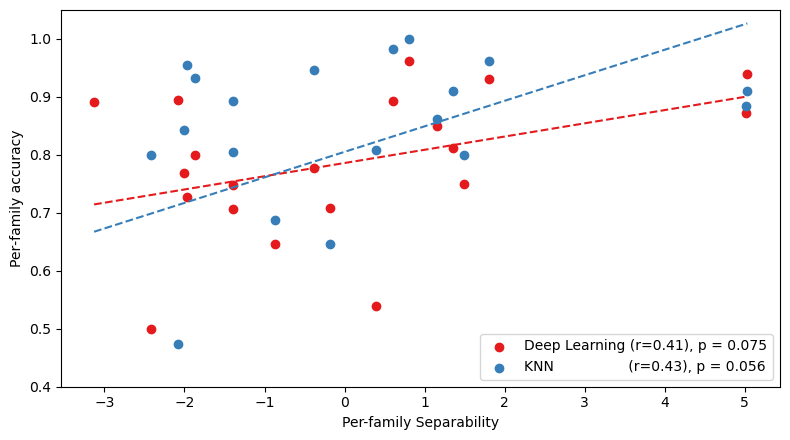

In [273]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=1)
difficulty_pc1 = pca.fit_transform(X_scaled).ravel()
df_summary['difficulty_pc1'] = difficulty_pc1

# r_DL  = np.corrcoef(difficulty_pc1, accuracy_DL )[0,1]
# r_KNN = np.corrcoef(difficulty_pc1, accuracy_KNN)[0,1]
# print(f"PC1 ↔ DL accuracy  r = {r_DL:.3f}")
# print(f"PC1 ↔ KNN accuracy r = {r_KNN:.3f}")

r_DL,  p_DL  = pearsonr(difficulty_pc1, accuracy_DL)
r_KNN, p_KNN = pearsonr(difficulty_pc1, accuracy_KNN)

print(f"DL:  Pearson r = {r_DL:.3f}, p = {p_DL:.3g}")
print(f"KNN: Pearson r = {r_KNN:.3f}, p = {p_KNN:.3g}")

plt.figure(figsize=(8,4.5))
plt.scatter(difficulty_pc1, accuracy_DL,
            label=f'Deep Learning (r={r_DL:.2f}), p = {p_DL:.2g}', color='#e41a1c')
plt.scatter(difficulty_pc1, accuracy_KNN,
            label=f'KNN                 (r={r_KNN:.2f}), p = {p_KNN:.2g}', color='#377eb8')

for y, col in [(accuracy_DL,'#e41a1c'), (accuracy_KNN,'#377eb8')]:
    m,b = np.polyfit(difficulty_pc1, y, 1)
    xs = np.array([difficulty_pc1.min(), difficulty_pc1.max()])
    plt.plot(xs, m*xs + b, linestyle='--', color=col)

plt.xlabel('Per-family Separability')
plt.ylabel('Per‑family accuracy')
plt.ylim(0.4,1.05)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()